In [68]:
import sklearn
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv("xiaosho.csv") 
df.shape

(2237, 25)

In [70]:
df.head()

,ID,Birth_Year,Education,Marital_Status,Income,Kids_At_Home,Teens_At_Home,Customer_Registration_Date,Wine_Expenses,Fruit_Expenses,...,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Per_Month,Accepted_Campaign_1,Accepted_Campaign_2,Accepted_Campaign_3,Accepted_Campaign_4,Accepted_Campaign_5,Accepted_Campaign_6
0,9970,1977,Graduação,Casado,"$55,375.00",0,1,10/17/13,42,11,...,1,1,6,2,0,0,0,0,0,0
1,4002,1960,PhD,Casado,"$77,037.00",0,1,10/13/13,463,96,...,7,7,12,3,0,0,0,0,0,0
2,10914,1970,Graduação,Solteiro,"$24,163.00",1,1,2010-12-13,4,1,...,1,0,3,4,0,0,0,0,0,0
3,7279,1969,PhD,Casado,"$69,476.00",0,0,9/30/13,260,86,...,4,6,4,2,0,0,0,0,0,0
4,10582,1979,Graduação,Casado,"$72,063.00",0,1,2007-03-13,180,32,...,5,2,12,2,0,0,0,0,0,0


In [71]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          2237 non-null   int64 
 1   Birth_Year                  2237 non-null   int64 
 2   Education                   2237 non-null   object
 3   Marital_Status              2237 non-null   object
 4   Income                      2213 non-null   object
 5   Kids_At_Home                2237 non-null   int64 
 6   Teens_At_Home               2237 non-null   int64 
 7   Customer_Registration_Date  2237 non-null   object
 8   Wine_Expenses               2237 non-null   int64 
 9   Fruit_Expenses              2237 non-null   int64 
 10  Meat_Expenses               2237 non-null   int64 
 11  Fish_Expenses               2237 non-null   int64 
 12  Sweet_Expenses              2237 non-null   int64 
 13  Other_Expenses              2237 non-null   int6

In [72]:
# Let's remove the extra space from the column headers
df.columns = df.columns.str.replace(' ', '')

In [73]:
df['Income'] = df['Income'].str.replace('$','').str.replace(',','').astype(float) 

In [74]:
df['Customer_Registration_Date'] = pd.to_datetime(df['Customer_Registration_Date'])

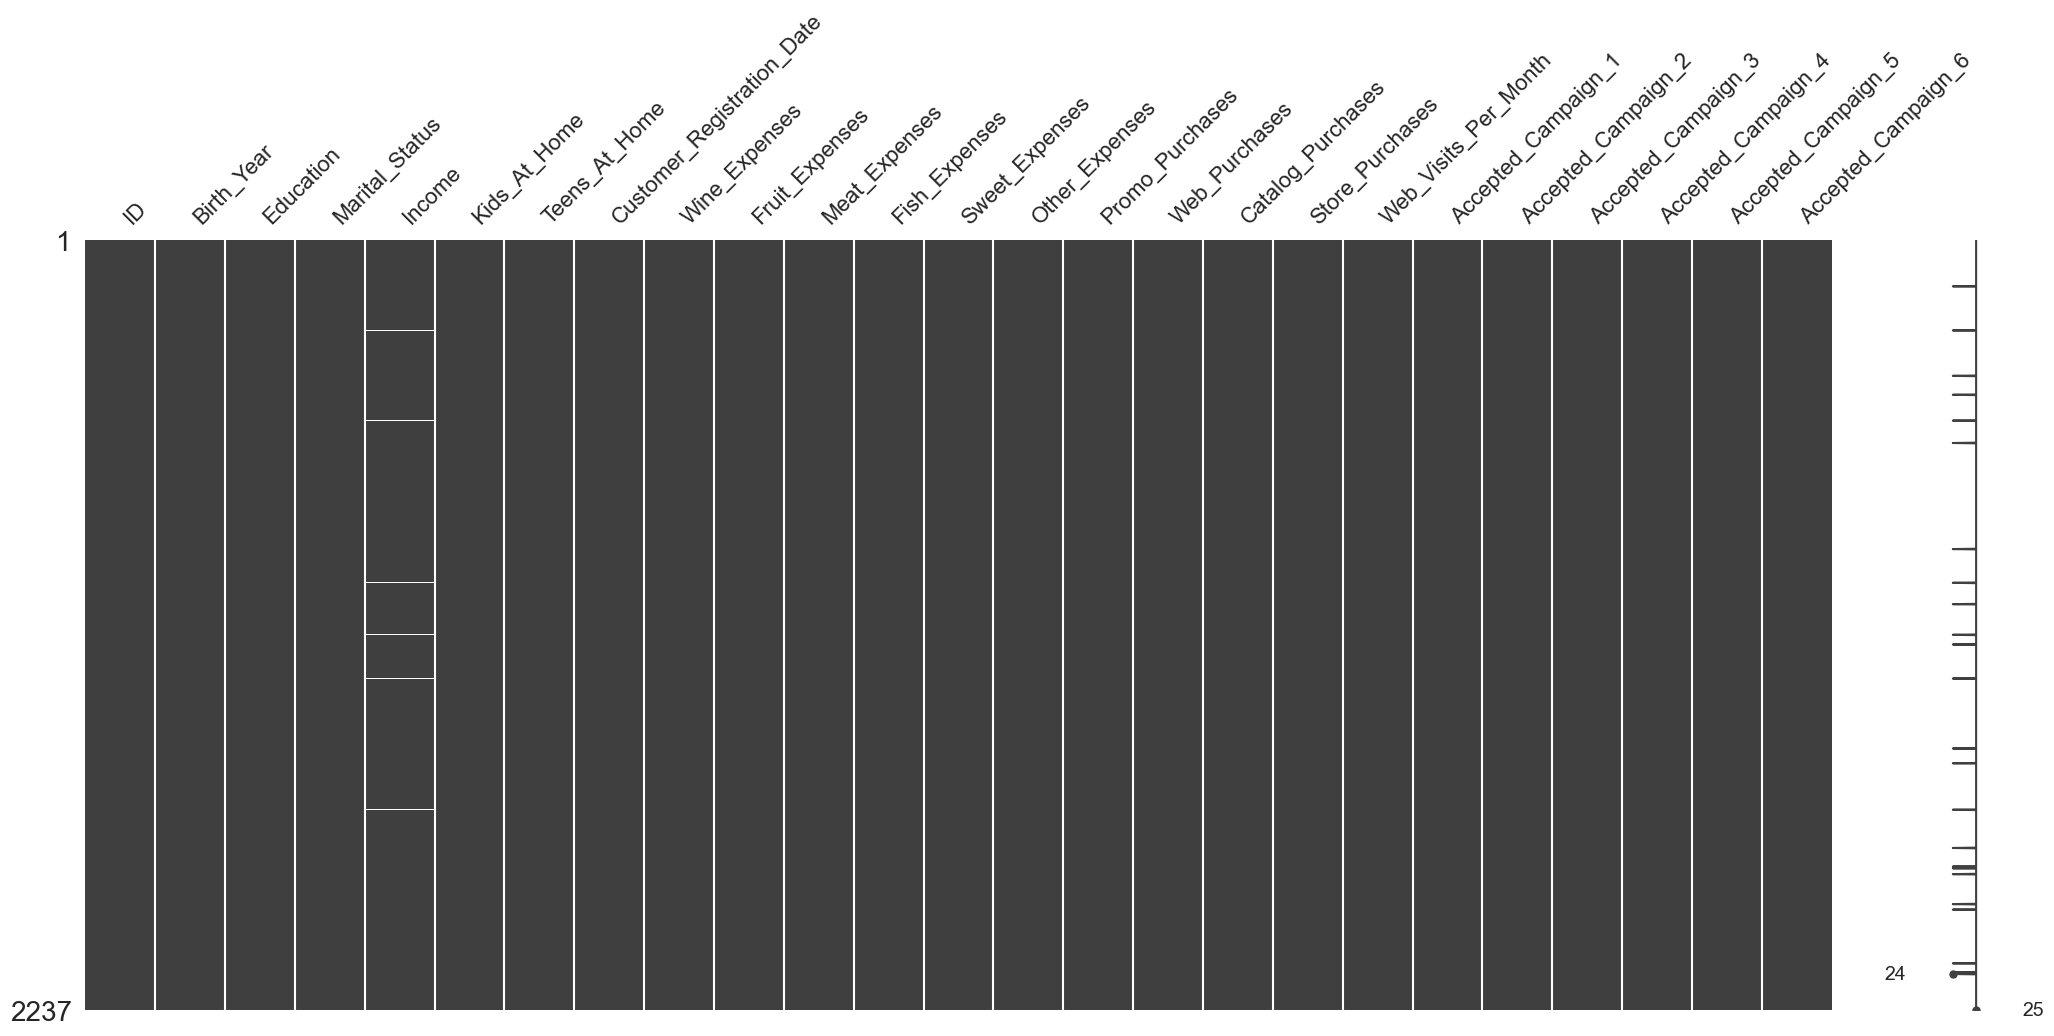

In [75]:
msno.matrix(df)
plt.show()

In [76]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values

Income                        24
ID                             0
Other_Expenses                 0
Accepted_Campaign_5            0
Accepted_Campaign_4            0
Accepted_Campaign_3            0
Accepted_Campaign_2            0
Accepted_Campaign_1            0
Web_Visits_Per_Month           0
Store_Purchases                0
Catalog_Purchases              0
Web_Purchases                  0
Promo_Purchases                0
Sweet_Expenses                 0
Birth_Year                     0
Fish_Expenses                  0
Meat_Expenses                  0
Fruit_Expenses                 0
Wine_Expenses                  0
Customer_Registration_Date     0
Teens_At_Home                  0
Kids_At_Home                   0
Marital_Status                 0
Education                      0
Accepted_Campaign_6            0
dtype: int64

In [77]:
 #We filter for those that are different from zero
print(missing_values.loc[missing_values != 0])

Income    24
dtype: int64


处理离群值，然后处理缺失值
缺失值需要解决，因为它们在各种情况下都会导致许多问题。有几种策略可以处理缺失值，其中许多策略都受相关变量的平均值的影响。但是，请务必记住，均值可能会受到异常值的影响.

在决定使用哪种策略来处理缺失值之前，最好检查是否存在异常值，并在必要时解决它们。异常值并不总是表示存在问题;它可能只是偏离了变量的平均值。 无论如何，异常值的存在都会影响我们处理缺失值的方式。

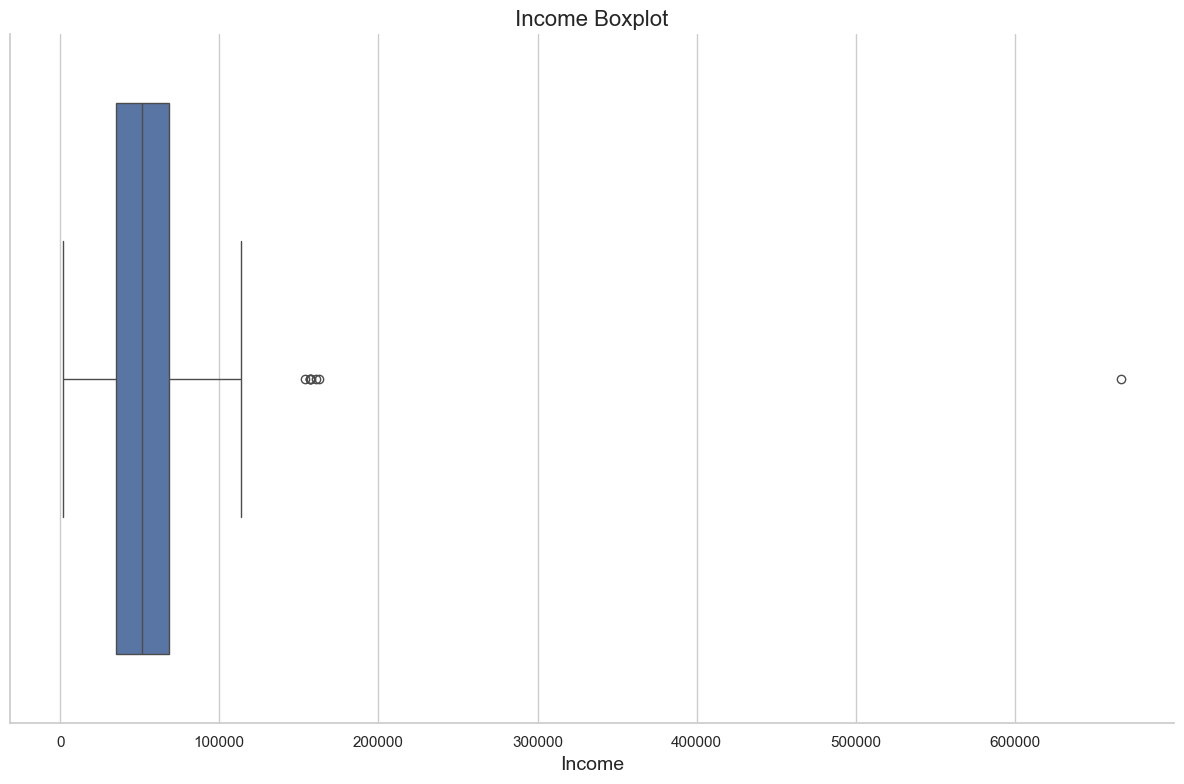

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust the figure size to fill the area
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure size

# Create the boxplot
sns.boxplot(x=df['Income'], ax=ax)

# Set title and labels
ax.set_title('Income Boxplot', fontsize=16)
ax.set_xlabel('Income', fontsize=14)

# Remove unnecessary borders and ensure a clean background
sns.despine()
ax.set_facecolor('white')

# Display the plot with tight layout
plt.tight_layout()
plt.show()

In [79]:
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

定义异常值限制：
接下来，我将定义边界以识别异常值。对于下限，我取 Q1 的值，即箱线图中箱体的下线，减去 1.5 乘以 IQR，这是统计标准。这将是我的下限。

In [80]:
lower_bound = Q1 - 1.5 * IQR # Bound 2
upper_bound = Q3 + 1.5 * IQR # Bound 1

In [81]:
outliers = df[(df['Income'] < lower_bound) | (df['Income'] > upper_bound)]
outliers

,ID,Birth_Year,Education,Marital_Status,Income,Kids_At_Home,Teens_At_Home,Customer_Registration_Date,Wine_Expenses,Fruit_Expenses,...,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Per_Month,Accepted_Campaign_1,Accepted_Campaign_2,Accepted_Campaign_3,Accepted_Campaign_4,Accepted_Campaign_5,Accepted_Campaign_6
325,4931,1977,Graduação,Casado,157146.0,0,0,2013-04-29,1,0,...,0,28,0,1,0,0,0,0,0,0
497,1501,1982,PhD,Casado,160803.0,0,0,2008-04-12,55,16,...,0,28,1,0,0,0,0,0,0,0
526,9432,1977,Graduação,Casado,666666.0,1,0,2006-02-13,9,14,...,3,1,3,6,0,0,0,0,0,0
730,1503,1976,PhD,Casado,162397.0,1,1,2006-03-13,85,1,...,0,0,1,1,0,0,0,0,0,0
851,5336,1971,Mestrado,Casado,157733.0,1,0,2006-04-13,39,1,...,1,0,1,1,0,0,0,0,0,0
1787,5555,1975,Graduação,Divorciado,153924.0,0,0,2002-07-14,1,1,...,0,0,0,0,0,0,0,0,0,0
1886,11181,1949,PhD,Casado,156924.0,0,0,2013-08-29,2,1,...,0,0,0,0,0,0,0,0,0,0
2165,8475,1973,PhD,Casado,157243.0,0,1,2003-01-14,20,2,...,0,22,0,0,0,0,0,0,0,0


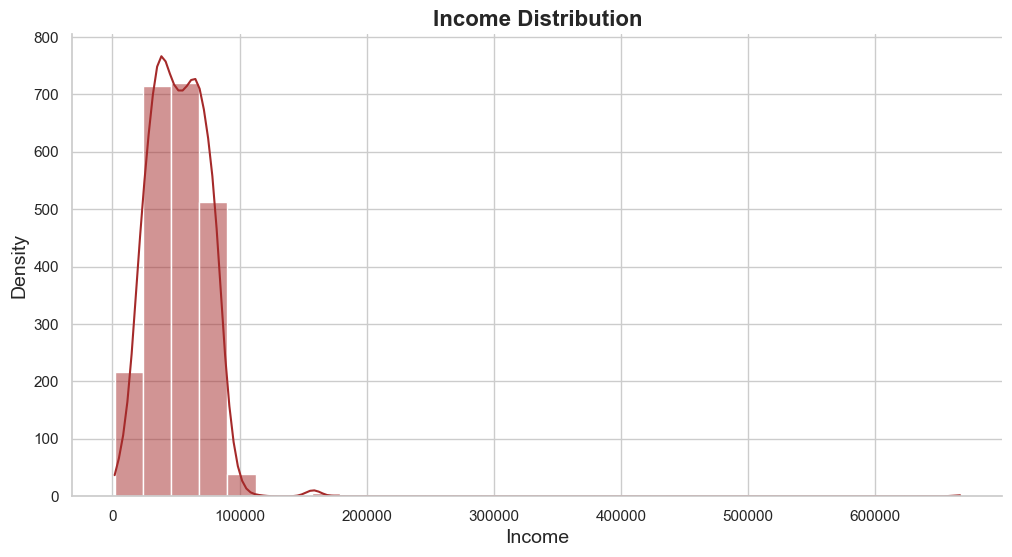

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the figure size
plt.figure(figsize=(12, 6))

# Creating the distribution plot
sns.histplot(df['Income'], kde=True, color='brown', bins=30)

# Setting the title and axis labels
plt.title('Income Distribution', size=16, weight='bold')
plt.xlabel('Income', size=14)
plt.ylabel('Density', size=14)

# Removing unnecessary borders
sns.despine()

# Displaying the plot
plt.show()

In [83]:
# Filtering the dataframe and removing the outliers
df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]

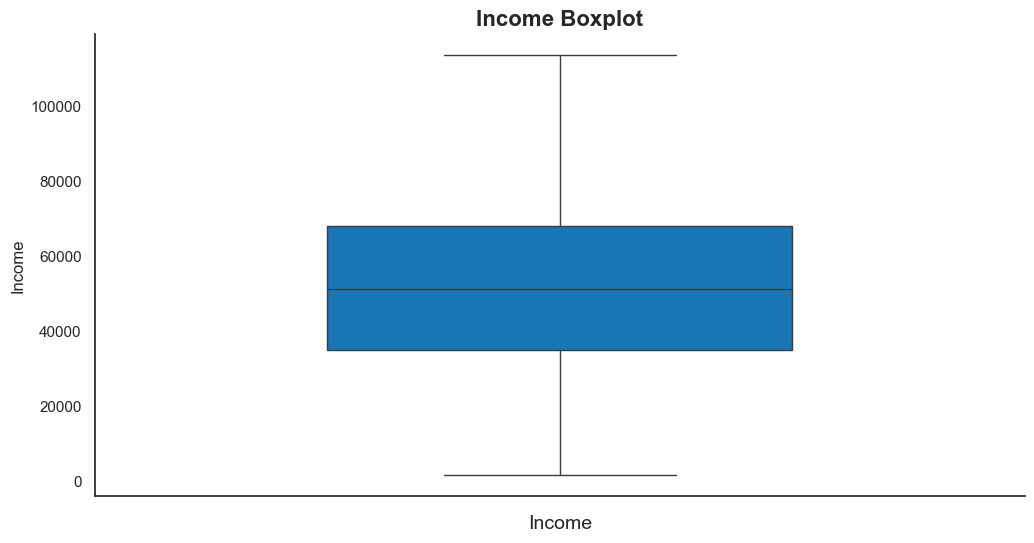

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting the figure size and removing gridlines
plt.figure(figsize=(12, 6))
sns.set(style="white")

# Creating a simple and clean boxplot
sns.boxplot(df['Income'], color='#007acc', width=0.5)

# Setting the title and X-axis label
plt.title('Income Boxplot', fontsize=16, weight='bold')
plt.xlabel('Income', fontsize=14)

# Removing unnecessary borders
sns.despine()

# Displaying the plot
plt.show()

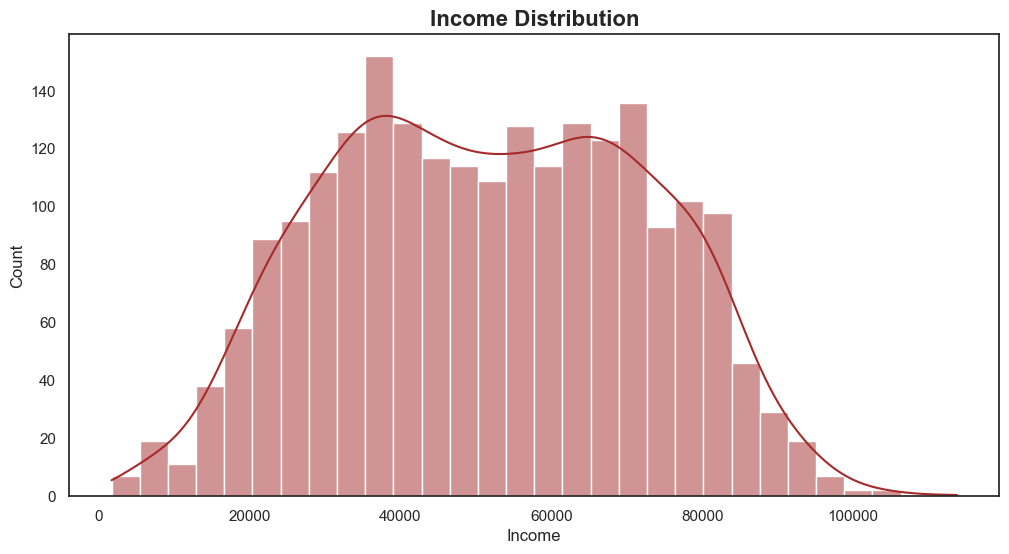

In [85]:
# Setting the figure size
plt.figure(figsize=(12, 6))

# Creating the distribution plot
sns.histplot(df['Income'], kde=True, color='brown', bins=30)

# Setting the title
plt.title('Income Distribution', fontsize=16, weight='bold')

# Displaying the plot
plt.show()

In [86]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Income']])

In [87]:
imputer = KNNImputer(n_neighbors=5)

In [88]:
# Impute the missing values with the imputer
data_imputed = imputer.fit_transform(data_scaled)

In [89]:
# Convert back to the original format
df['Income'] = scaler.inverse_transform(data_imputed)

In [90]:
print('Total Missing Values:', df.isnull().sum().sum())

Total Missing Values: 0


In [91]:
df.columns

Index(['ID', 'Birth_Year', 'Education', 'Marital_Status', 'Income',
       'Kids_At_Home', 'Teens_At_Home', 'Customer_Registration_Date',
       'Wine_Expenses', 'Fruit_Expenses', 'Meat_Expenses', 'Fish_Expenses',
       'Sweet_Expenses', 'Other_Expenses', 'Promo_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Per_Month',
       'Accepted_Campaign_1', 'Accepted_Campaign_2', 'Accepted_Campaign_3',
       'Accepted_Campaign_4', 'Accepted_Campaign_5', 'Accepted_Campaign_6'],
      dtype='object')

In [92]:
data_boxplot = df.drop(columns = ['ID',
                                      'Education',
                                      'Marital_Status',
                                      'Kids_At_Home',
                                      'Customer_Registration_Date',
                                      'Teens_At_Home',
                                      'Accepted_Campaign_1',
                                      'Accepted_Campaign_2',
                                      'Accepted_Campaign_3',
                                      'Accepted_Campaign_4',
                                      'Accepted_Campaign_5',
                                      'Accepted_Campaign_6'])

In [93]:
data_boxplot.columns

Index(['Birth_Year', 'Income', 'Wine_Expenses', 'Fruit_Expenses',
       'Meat_Expenses', 'Fish_Expenses', 'Sweet_Expenses', 'Other_Expenses',
       'Promo_Purchases', 'Web_Purchases', 'Catalog_Purchases',
       'Store_Purchases', 'Web_Visits_Per_Month'],
      dtype='object')

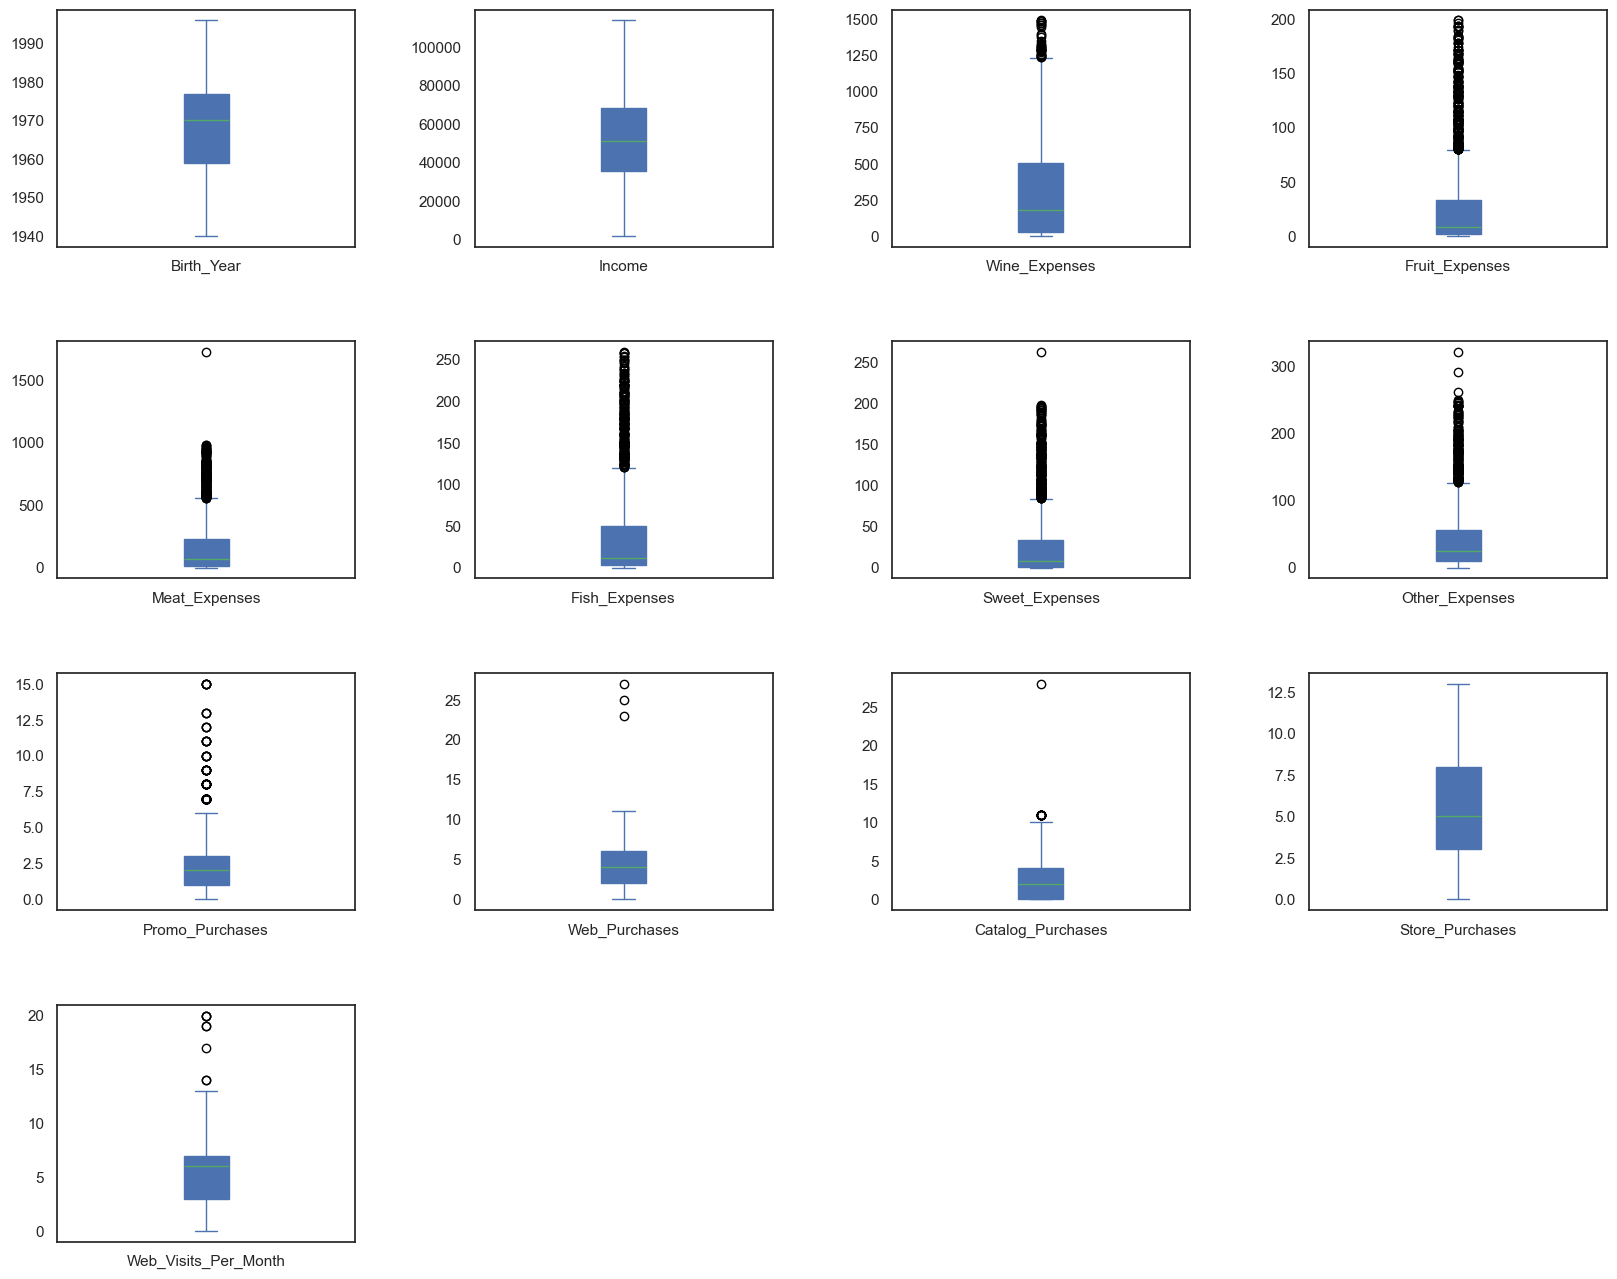

In [94]:
# Adjust to 4x4 subplots to better fill the space
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
data_boxplot.plot(subplots=True, layout=(4, 4), kind='box', ax=axes.flatten()[:13], patch_artist=True)

# Remove empty subplots
for i in range(13, 16):
    fig.delaxes(axes.flatten()[i])

# Adjust spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

什么是特征工程？
特征工程旨在提取隐藏的信息并使其清晰透明，以便我们可以进行分析。以 Birth_Year为例，这是我们的第一个箱线图。它显示每个客户的出生年份。

用每个客户的年龄替换这个变量会更有趣吗？年龄已经存在了吗？是的，但它是隐藏的。如何计算年龄？这是当前年份减去出生年份。这给了我们客户的确切年龄。换句话说，时代就在那里——它只是被隐藏了.

要使这些信息透明，我该怎么办？我应用特征工程。这只是一个例子。

特征工程的最大挑战是它非常主观。作为分析师或数据科学家，您需要付出努力来看待问题、分析数据并尝试从不同的角度看待问题。许多人在日常工作中没有为此投入时间。

当你有很多变量时，通常会有很多隐藏的信息！ 我刚才提到的 age 例子就是一个很好的例子。还有更多 — 这个数据集中隐藏着许多见解。现在，我将深入研究所有这些，并使用特征工程使这些见解透明化。

此外，在为 Machine Learning 准备数据时，特征工程通常非常有用。您可以通过应用特征工程来降低数据维度。

In [95]:
current_year = datetime.now().year
df['Age'] = current_year - df['Birth_Year']

In [96]:
df['Days_As_Customer'] = df['Customer_Registration_Date'].max() - df['Customer_Registration_Date']

In [97]:
df['Days_As_Customer'] = df['Days_As_Customer'].astype(str).str.replace(' days', '')

In [98]:
df['Days_As_Customer'] = pd.to_numeric(df['Days_As_Customer'], downcast='integer')

In [99]:
# Criar uma variável para o Total de Compras feitas nos 3 diferentes canais
df['Total_Purchases'] = df['Web_Purchases'] + df['Catalog_Purchases'] + df['Store_Purchases']

In [100]:
# Create the Total_Spend variable with the sum of all columns that start with the name 'Expense'
df['Total_Spend'] = df.filter(like='Expense').sum(axis=1)

In [101]:
# create a variable to indicate if the customer accepted any campaign (and purchased the offered product)
df['campaign_accepted'] = df.filter(like='Accepted').sum(axis=1)

In [102]:
df['Accepted_Campaign_1'].value_counts()
df['Accepted_Campaign_2'].value_counts()

Accepted_Campaign_2
0    2041
1     164
Name: count, dtype: int64

In [103]:
df.sample(10)

,ID,Birth_Year,Education,Marital_Status,Income,Kids_At_Home,Teens_At_Home,Customer_Registration_Date,Wine_Expenses,Fruit_Expenses,...,Accepted_Campaign_2,Accepted_Campaign_3,Accepted_Campaign_4,Accepted_Campaign_5,Accepted_Campaign_6,Age,Days_As_Customer,Total_Purchases,Total_Spend,campaign_accepted
1993,221,1955,Graduação,Casado,48726.0,0,1,2013-04-27,138,3,...,0,0,0,0,0,69,428,9,242,0
933,1927,1973,Ensino Médio,Casado,69401.0,0,1,2014-03-23,399,27,...,0,0,0,0,0,51,98,13,690,0
220,3376,1970,Mestrado,Divorciado,55282.0,1,0,2013-12-13,125,6,...,0,0,0,0,0,54,198,10,235,0
1470,2611,1959,Mestrado,Casado,82576.0,0,0,2008-01-12,1206,55,...,0,1,0,0,0,65,2360,18,1910,1
1775,9120,1962,Graduação,Solteiro,66565.0,0,1,2012-05-12,747,10,...,0,0,0,0,0,62,778,15,1065,0
1771,702,1975,Ensino Médio,Viúvo,47682.0,0,1,2013-02-15,162,61,...,0,0,0,0,0,49,499,15,521,0
614,762,1981,Ensino Médio,Casado,75774.0,1,0,2005-02-14,340,21,...,0,0,0,0,0,43,3422,20,823,0
928,4643,1973,Graduação,Casado,27803.0,1,0,2012-08-26,8,26,...,0,0,0,0,0,51,672,7,176,0
1398,6661,1974,Graduação,Casado,67445.0,0,1,2008-12-12,757,80,...,0,0,0,0,0,50,2025,27,1174,0
1063,9283,1978,Graduação,Solteiro,60199.0,1,2,2009-12-13,8,1,...,0,0,0,0,0,46,1659,3,18,0


In [104]:
# Let's adjust the data type and place it in a new column
df['Campaign_Response'] = df['campaign_accepted'].apply(lambda x: 'Accepted' if x > 0 else 'Not Accepted')

In [105]:
# Let's observe a random sample of the variables we created
df[['Age', 'Days_As_Customer', 'Total_Purchases', 'Total_Spend', 'Campaign_Response']].sample(10)

,Age,Days_As_Customer,Total_Purchases,Total_Spend,Campaign_Response
1014,47,3241,5,31,Not Accepted
1186,51,185,7,57,Not Accepted
415,37,124,26,778,Not Accepted
600,45,367,4,36,Not Accepted
50,52,3514,3,8,Not Accepted
855,35,468,3,18,Not Accepted
2078,45,624,4,29,Not Accepted
348,48,467,23,1581,Not Accepted
1155,41,2998,3,10,Not Accepted
1911,64,438,4,25,Not Accepted


In [106]:
# We no longer need these variables
df.drop(['Birth_Year', 
         'Customer_Registration_Date', 
         'campaign_accepted'], axis=1, inplace=True)

In [107]:
df.describe()

,ID,Income,Kids_At_Home,Teens_At_Home,Wine_Expenses,Fruit_Expenses,Meat_Expenses,Fish_Expenses,Sweet_Expenses,Other_Expenses,...,Accepted_Campaign_1,Accepted_Campaign_2,Accepted_Campaign_3,Accepted_Campaign_4,Accepted_Campaign_5,Accepted_Campaign_6,Age,Days_As_Customer,Total_Purchases,Total_Spend
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.00000,2205.000000,2205.000000,2205.000000,2205.000000
mean,5585.439456,51622.094785,0.442177,0.506576,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,0.073923,0.074376,0.073016,0.064399,0.013605,0.15102,55.095692,1307.092971,12.569615,606.821769
std,3247.546423,20713.063826,0.537132,0.544380,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,...,0.261705,0.262442,0.260222,0.245518,0.115872,0.35815,11.705801,1429.824606,7.180350,601.675284
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,28.000000,0.000000,0.000000,5.000000
25%,2815.000000,35196.000000,0.000000,0.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,47.000000,286.000000,6.000000,69.000000
50%,5455.000000,51287.000000,0.000000,0.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.000000,583.000000,12.000000,397.000000
75%,8418.000000,68281.000000,1.000000,1.000000,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,65.000000,2116.000000,18.000000,1047.000000
max,11191.000000,113734.000000,2.000000,2.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,84.000000,4915.000000,32.000000,2525.000000


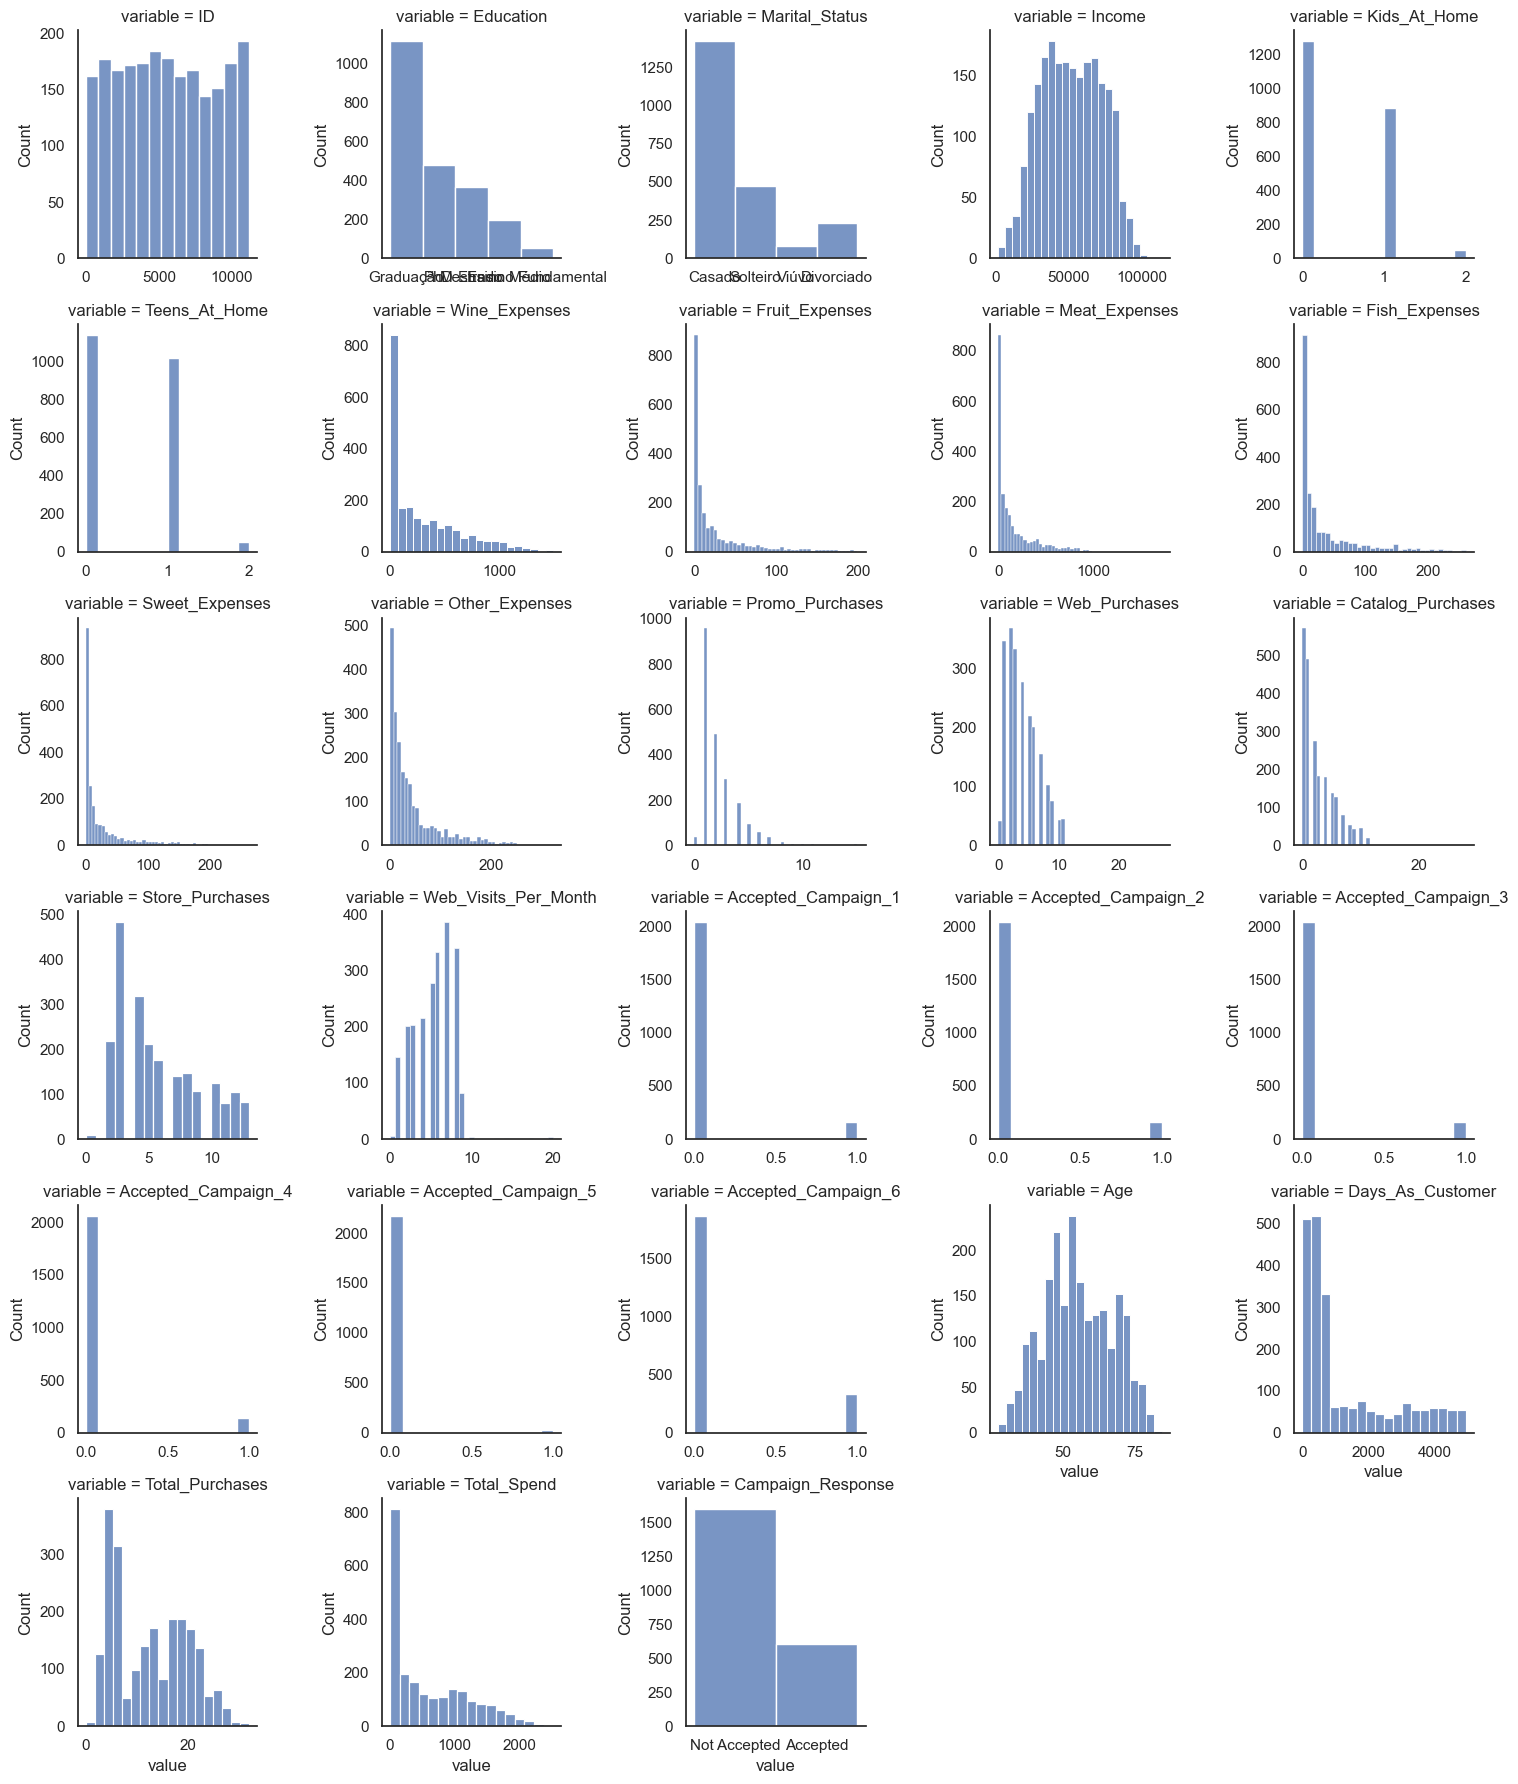

In [108]:
# Distribution of Variables
hist = pd.melt(df, value_vars=df.columns)
hist = sns.FacetGrid(hist, col='variable', col_wrap=5, sharex=False, sharey=False)
hist.map(sns.histplot, 'value')

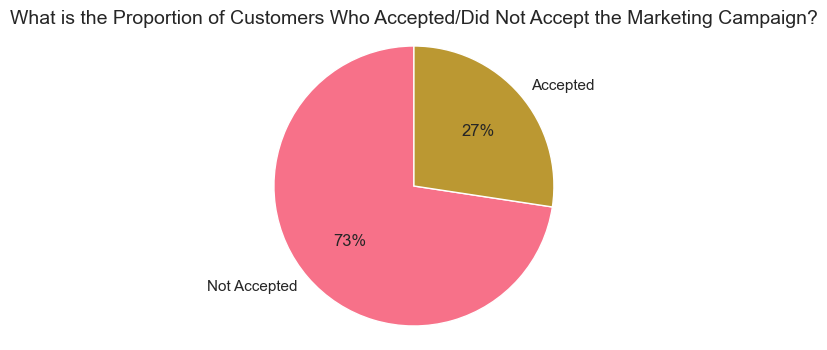

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct column name
counts = df['Campaign_Response'].value_counts()
labels = counts.index.tolist()

# Figure size
fig, ax = plt.subplots(figsize=(6, 4))

# Color palette
colors = sns.color_palette('husl')

# Pie chart
ax.pie(counts, labels=labels, colors=colors, autopct='%.0f%%', startangle=90)

# Title
ax.set_title('What is the Proportion of Customers Who Accepted/Did Not Accept the Marketing Campaign?', fontsize=14)

# Keep axes equal
ax.axis('equal')

# Display 
plt.show()

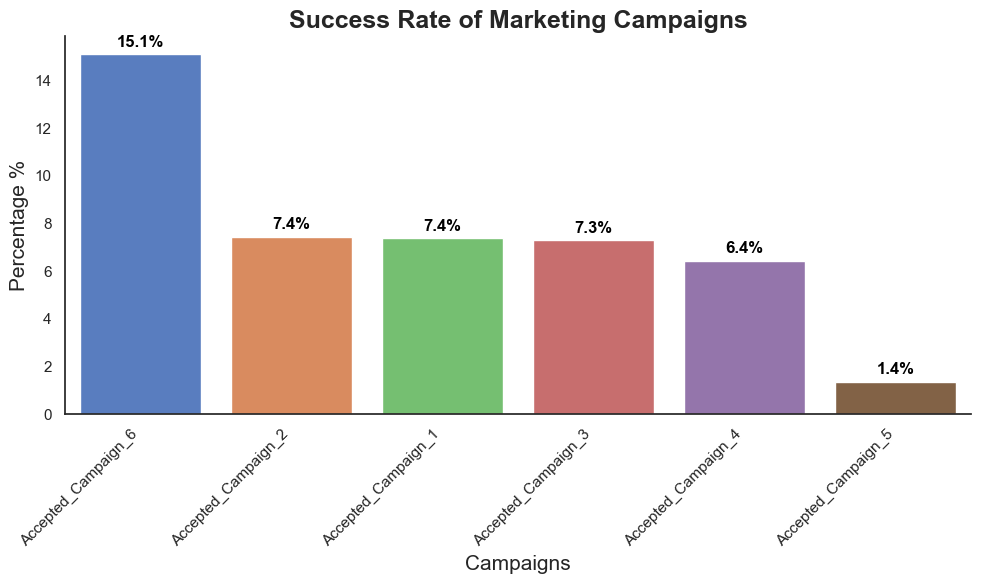

In [110]:
campaigns = ['Accepted_Campaign_1',
             'Accepted_Campaign_2',
             'Accepted_Campaign_3',
             'Accepted_Campaign_4',
             'Accepted_Campaign_5',
             'Accepted_Campaign_6']

# Calculate the percentage
campaigns = pd.DataFrame(df[campaigns].mean() * 100, columns=['Percent']).reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='index', y='Percent', data=campaigns.sort_values('Percent', ascending=False), palette='muted')

# Labels
ax.set_xlabel('Campaigns', size=15)
ax.set_ylabel('Percentage %', size=15)
ax.set_title('Success Rate of Marketing Campaigns', size=18, weight='bold')

# Include percentage on the graph
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, 
                 p.get_height() + 0.5),  # Positioning slightly above the bar
                ha='center', 
                va='center', 
                fontsize=12, color='black', weight='bold')

# Remove unnecessary borders and ticks
sns.despine()
ax.tick_params(bottom=False, left=False)

# Rotate X-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display
plt.tight_layout()
plt.show()

In [111]:
# Filter categorical columns and calculate the correlation of quantitative columns
df_corr = df.drop(['ID',
                   'Education',
                   'Marital_Status',
                   'Kids_At_Home',
                   'Teens_At_Home',
                   'Accepted_Campaign_1', 
                   'Accepted_Campaign_2',
                   'Accepted_Campaign_3', 
                   'Accepted_Campaign_4', 
                   'Accepted_Campaign_5',
                   'Accepted_Campaign_6', 
                   'Campaign_Response'], axis=1).corr()

In [112]:
# Find correlation with the 'Age' column
column_corr = df_corr.loc['Age']

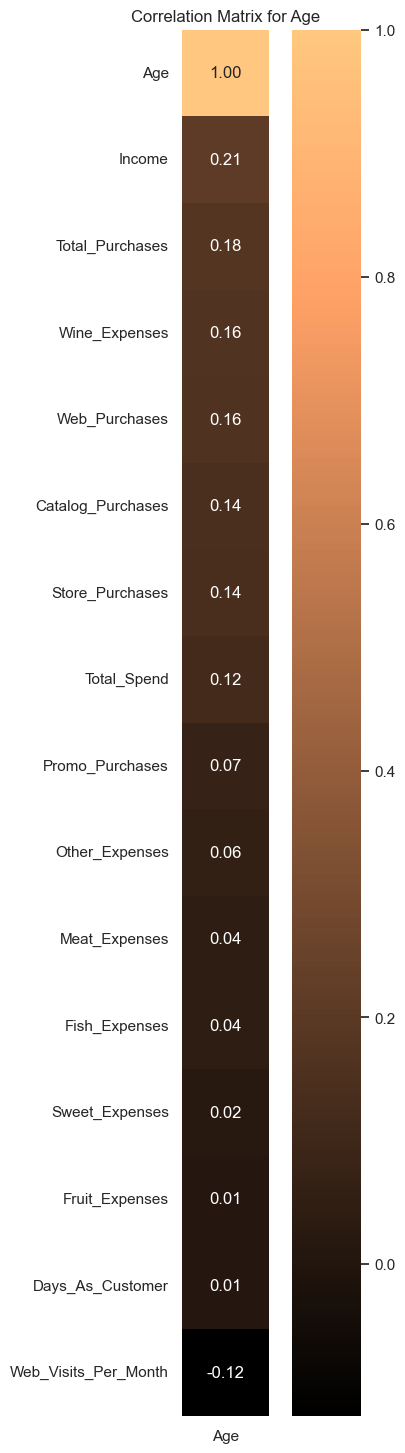

In [113]:
# Plot
plt.figure(figsize=(6, 18))
sns.heatmap(pd.DataFrame(column_corr.sort_values(ascending=False)), 
            annot=True, 
            cmap='copper', 
            cbar=True,
            square=True,
            fmt='.2f')
plt.title('Correlation Matrix for Age')
plt.show()

<Axes: xlabel='Campaign_Response', ylabel='Total_Spend'>

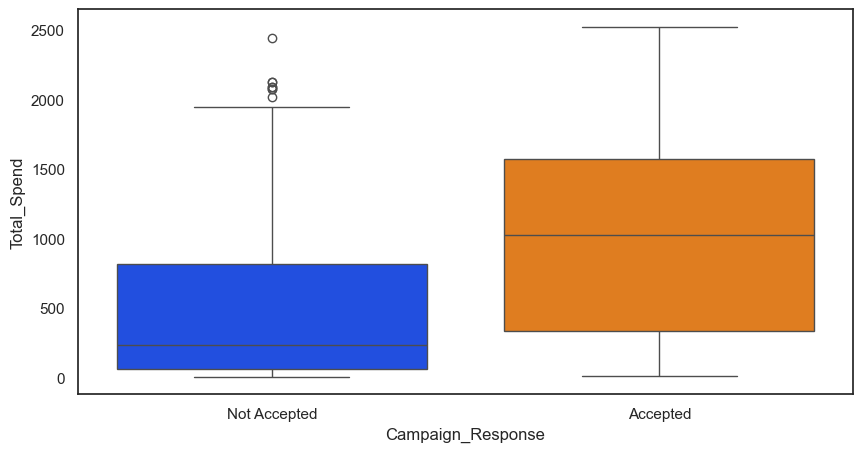

In [114]:
# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Campaign_Response', y='Total_Spend', data=df, palette='bright')

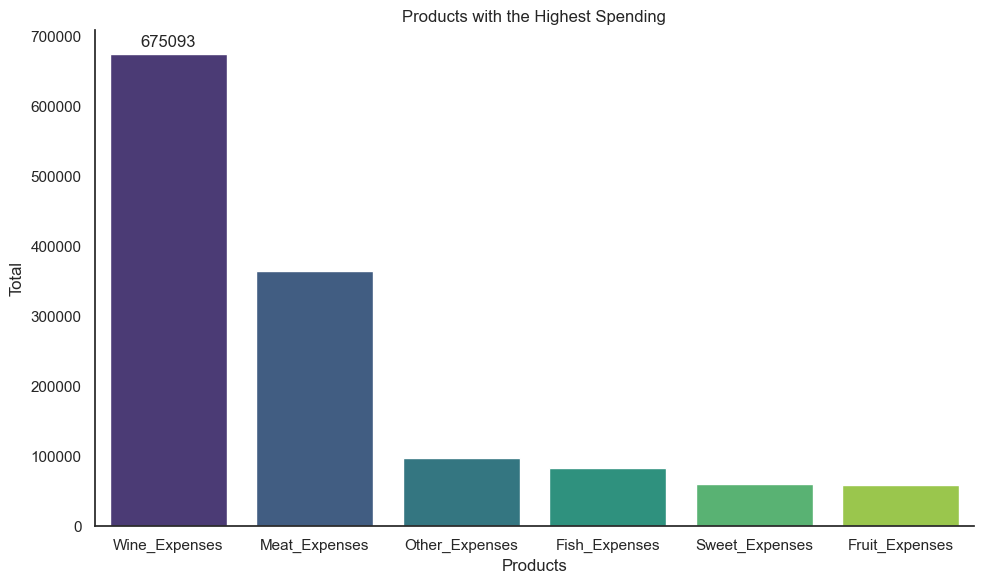

In [115]:
# Product categories and totals
products = ['Wine_Expenses', 'Fruit_Expenses', 'Meat_Expenses', 'Fish_Expenses', 'Sweet_Expenses', 'Other_Expenses']
df_products = df[products].sum().sort_values(ascending=False).reset_index(name='Sum')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='index', y='Sum', data=df_products, palette='viridis')

# Labels, title, and annotations
ax.set(xlabel='Products', ylabel='Total', title='Products with the Highest Spending')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3)

# Clean up
sns.despine()
plt.tight_layout()
plt.show()

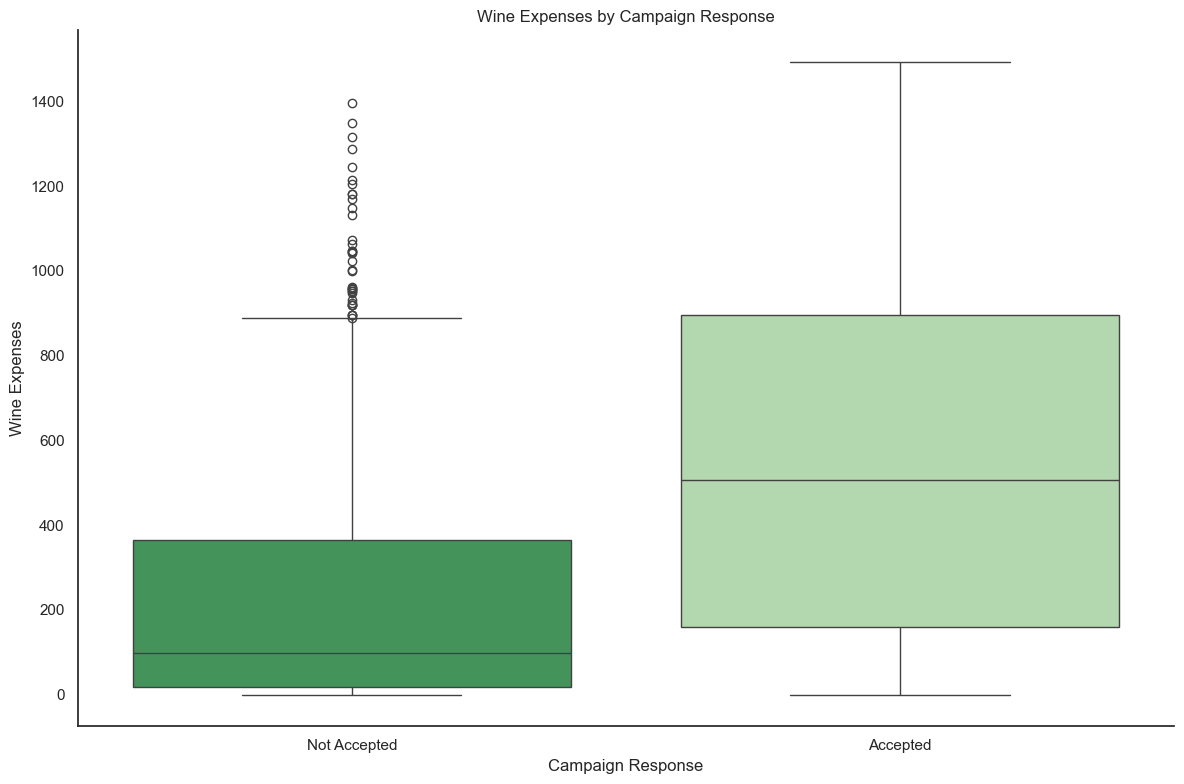

In [116]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Campaign_Response', y='Wine_Expenses', data=df, palette='Greens_r')
ax.set(xlabel='Campaign Response', ylabel='Wine Expenses', title='Wine Expenses by Campaign Response')
sns.despine()
plt.tight_layout()
plt.show()

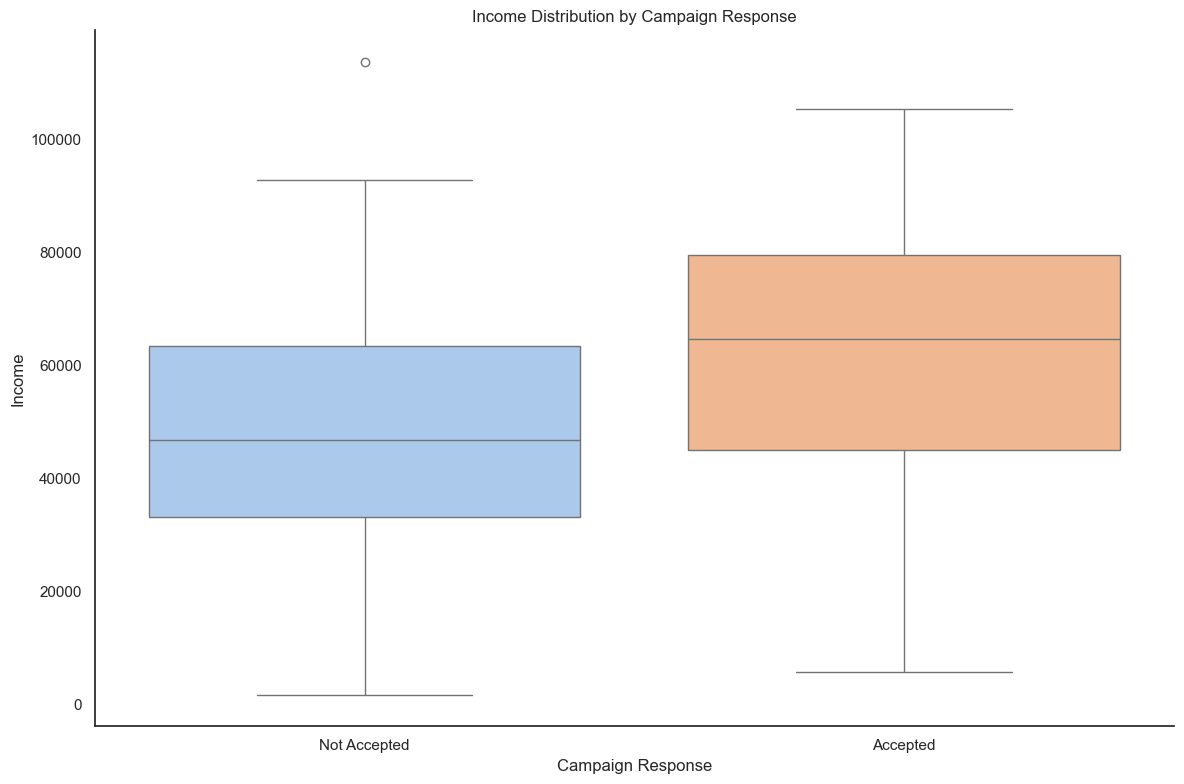

In [117]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='Campaign_Response', y='Income', data=df, palette='pastel', ax=ax)
ax.set(xlabel='Campaign Response', ylabel='Income', title='Income Distribution by Campaign Response')
sns.despine()
plt.tight_layout()
plt.show()

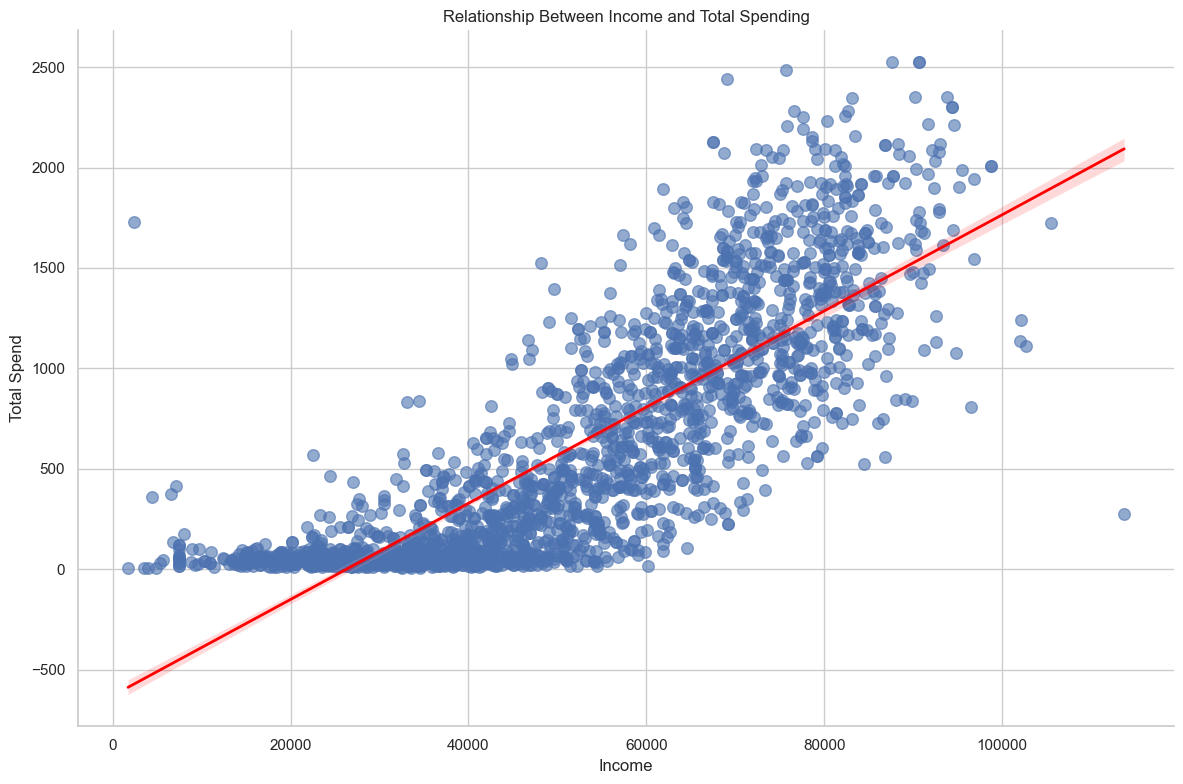

In [118]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='Income', y='Total_Spend', data=df, 
            scatter_kws={'s': 70, 'alpha': 0.6}, 
            line_kws={'color': 'red', 'linewidth': 2},
            ax=ax)
ax.set(xlabel='Income', ylabel='Total Spend', title='Relationship Between Income and Total Spending')
sns.despine()
plt.tight_layout()
plt.show()

In [119]:
df_imp = pd.get_dummies(df, columns=['Education', 'Marital_Status'])
df_imp.columns

Index(['ID', 'Income', 'Kids_At_Home', 'Teens_At_Home', 'Wine_Expenses',
       'Fruit_Expenses', 'Meat_Expenses', 'Fish_Expenses', 'Sweet_Expenses',
       'Other_Expenses', 'Promo_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Per_Month',
       'Accepted_Campaign_1', 'Accepted_Campaign_2', 'Accepted_Campaign_3',
       'Accepted_Campaign_4', 'Accepted_Campaign_5', 'Accepted_Campaign_6',
       'Age', 'Days_As_Customer', 'Total_Purchases', 'Total_Spend',
       'Campaign_Response', 'Education_Ensino Fundamental',
       'Education_Ensino Médio', 'Education_Graduação', 'Education_Mestrado',
       'Education_PhD', 'Marital_Status_Casado', 'Marital_Status_Divorciado',
       'Marital_Status_Solteiro', 'Marital_Status_Viúvo'],
      dtype='object')

In [120]:
X = df_imp.drop(['ID',
                 'Wine_Expenses', 
                 'Fruit_Expenses', 
                 'Meat_Expenses', 
                 'Fish_Expenses',
                 'Sweet_Expenses', 
                 'Other_Expenses',
                 'Web_Purchases', 
                 'Catalog_Purchases', 
                 'Store_Purchases',
                 'Accepted_Campaign_1', 
                 'Accepted_Campaign_2', 
                 'Accepted_Campaign_3', 
                 'Accepted_Campaign_4', 
                 'Accepted_Campaign_5', 
                 'Accepted_Campaign_6',
                 'Campaign_Response'], axis=1)

In [121]:
# Convert the variable into a numerical representation
y = df_imp['Campaign_Response'].map({'Not Accepted': 0, 'Accepted': 1})

In [122]:
# Create the model
rf_model = RandomForestClassifier(random_state=43)

In [123]:
# Train the model
rf_model = rf_model.fit(X, y)

In [124]:
# Extract the importance of each variable
importances = rf_model.feature_importances_

In [125]:
# Standard deviation of feature importances
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

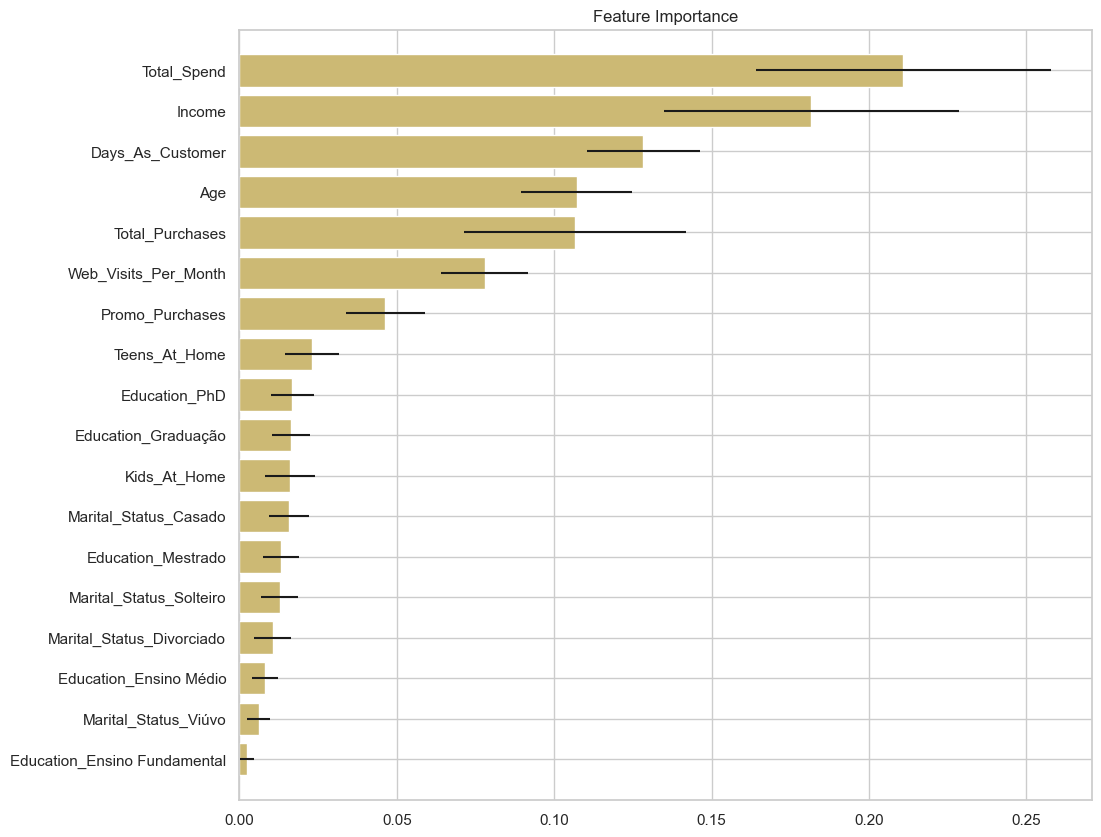

In [126]:
# Indexes
indexes = np.argsort(importances)

# Plot
plt.figure(1, figsize=(11, 10))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indexes], color="y", xerr=std[indexes], align="center")
plt.yticks(range(X.shape[1]), X.columns[indexes])
plt.ylim([-1, X.shape[1]])
plt.show()

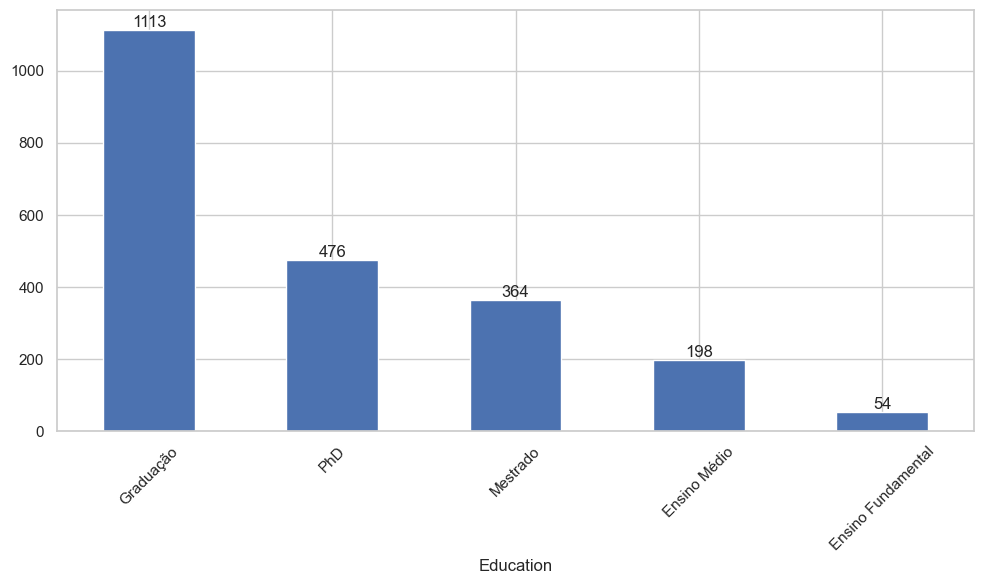

In [127]:
# Plot total customers by educational level
plt.figure(figsize=(10, 6))
ax = df.Education.value_counts().plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.bar_label(ax.containers[0])
plt.tight_layout()  
plt.show();

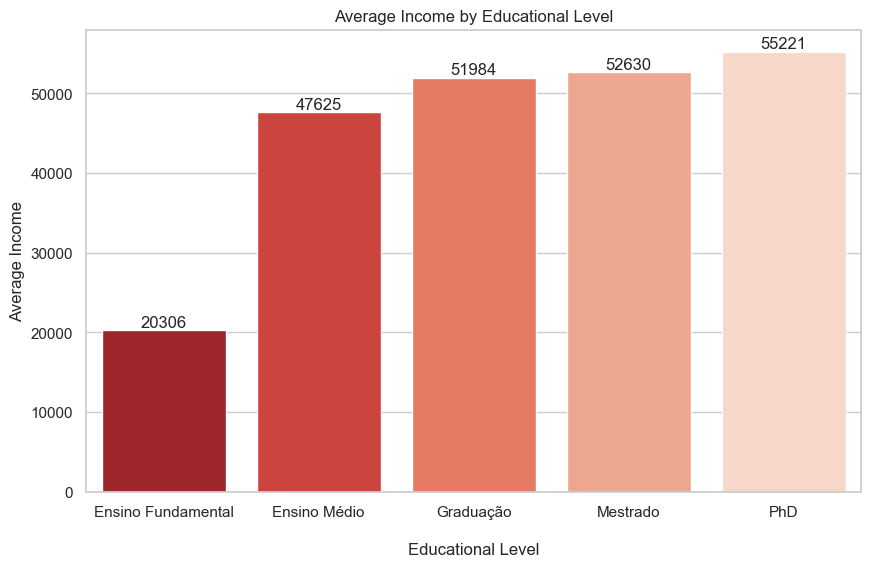

In [128]:
# Calculate the average
average_income = df.groupby('Education')['Income'].mean().reset_index()
average_income = average_income.sort_values(by='Income')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_income['Education'], y=average_income['Income'], palette='Reds_r')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', 
                va='bottom')
plt.xlabel('\nEducational Level')
plt.ylabel('Average Income')
plt.title('Average Income by Educational Level')
plt.show()

In [129]:
df['Education'] = df['Education'].map({'Elementary School': 1,
                                       'High School': 2,
                                       'Graduate': 3,
                                       'Master': 4,
                                       'PhD': 5})

In [130]:
# Data to be tested
test_data = df[['Income', 'Education']]
test_data.head()

,Income,Education
0,55375.0,NaN
1,77037.0,5.0
2,24163.0,NaN
3,69476.0,5.0
4,72063.0,NaN


In [131]:
from scipy.stats import shapiro

def test_normality(columns):
    for col in columns:
        statistic, p_value = shapiro(test_data[col])
        alpha = 0.05
        
        if p_value < alpha:
            print(f'\n{col}: Alpha {alpha} < p-value {p_value:.2f} - Rejecting H0: The data is not normally distributed.')
        else:
            print(f'\n{col}: Alpha {alpha} > p-value {p_value:.2f} - Failing to Reject H0: The data follows a normal distribution.')

# Example usage
test_normality(test_data.columns)


Income: Alpha 0.05 < p-value 0.00 - Rejecting H0: The data is not normally distributed.

Education: Alpha 0.05 > p-value 1.00 - Failing to Reject H0: The data follows a normal distribution.


In [132]:
# Creating the groups
group_with_degree = df[df['Education'].isin([5, 4, 3])]['Income']
group_without_degree = df[df['Education'].isin([1, 2])]['Income']

In [ ]:
# Mann-Whitney U Test
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(group_with_degree, group_without_degree)

# Significance level
alpha = 0.02

# Result
if p_value < alpha:
    print("We reject the null hypothesis: There is a significant difference in income averages.")
else:
    print("We fail to reject the null hypothesis: There is no significant difference in income averages.")